In [2]:
import os
from PIL import Image
import timeit
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.io as io
import torch.optim as optim
import matplotlib.pyplot as plt
import gc

# 3) Multi label classification

### 3.1 Data analysis and preprocessing

In [3]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image.clone().detach(), label.clone().detach().long()

In [4]:
def load_mnist_data_mod(dataset_path):
    splits = ['train', 'val', 'test']
    data = {}

    for split in splits:
        images = []
        labels = []
        split_path = os.path.join(dataset_path, split)
        print(split_path)
        for label_folder in os.listdir(split_path):
            label_folder_path = os.path.join(split_path, label_folder)

            if not os.path.isdir(label_folder_path):
                continue
            if label_folder == '0':
                label = '___'
            else:
                if len(label_folder) == 1:
                    label = label_folder+"__"
                elif len(label_folder) == 2:
                    label = label_folder+"_"
                else:
                    label = label_folder

            for img_file in os.listdir(label_folder_path):
                img_path = os.path.join(label_folder_path, img_file)
                if not os.path.isfile(img_path):
                    continue
                
                img = Image.open(img_path).convert('L')
                images.append(img)
                labels.append(label)

        data[split] = (images, labels)

    return data['train'], data['val'], data['test']

train_data, val_data, test_data = load_mnist_data_mod('/kaggle/input/double-mnist/double_mnist')
# train_data, val_data, test_data = load_mnist_data('/Users/shravangadbail/Desktop/College/3.1/SMAI/Assignments/smai-m24-assignments-ShravanGadbail/data/external/double_mnist')

/kaggle/input/double-mnist/double_mnist/train
/kaggle/input/double-mnist/double_mnist/val
/kaggle/input/double-mnist/double_mnist/test


In [5]:
train_images, train_labels = train_data
val_images, val_labels = val_data
test_images, test_labels = test_data

In [6]:
def one_hot_encode(labels):
    one_hot_labels = torch.zeros(len(labels), 33)
    for j in range(len(labels)):
        if labels[j] == "___":
            one_hot_labels[j,10] = 1
            one_hot_labels[j,21] = 1
            one_hot_labels[j,32] = 1
        i = 0
        for c in labels[j]:
            if c == '_':
                one_hot_labels[j,i+10] = 1
            else:
                one_hot_labels[j,i+ord(c)-ord('0')] = 1
            i += 11
    return one_hot_labels

# unique_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_']
# train_OHE = one_hot_encode_labels(train_labels, unique_labels)
# val_OHE = one_hot_encode_labels(val_labels, unique_labels)
# test_OHE = one_hot_encode_labels(test_labels, unique_labels)

train_OHE = one_hot_encode(train_labels)
val_OHE = one_hot_encode(val_labels)
test_OHE = one_hot_encode(test_labels)

# print(train_labels[4700:4810],train_OHE[4700:4710])
# print(train_labels[:5],train_OHE[:5])

In [7]:
transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor()])

train_df = MultiMNISTDataset(train_images, train_OHE, transform=transform)
val_df = MultiMNISTDataset(val_images, val_OHE, transform=transform)
test_df = MultiMNISTDataset(test_images, test_OHE, transform=transform)

train = DataLoader(train_df, batch_size=32, shuffle=True)
val = DataLoader(val_df, batch_size=32, shuffle=False)
test = DataLoader(test_df, batch_size=32, shuffle=False)

### 3.2 Implement the Multilabel CNN class

### 1. Define the convolutional layers, activation functions, pooling layers, and dropout layers necessary for the architecture.
### 2. Implement the forward() method that takes input data and passes it through the defined layers sequentially. (13 Marks)


In [8]:
class MultiLabelCNN(nn.Module):
    def __init__(self, size=(32, 1, 128, 128), optimizer='Adam', activation='relu', pool_type='max', 
                 stride=2, num_conv_layers=2, conv_kernel_size=3, pool_kernel_size=2, 
                 num_classes=33, dropout_rate=0.5):
        super(MultiLabelCNN, self).__init__()
        self.num_classes = num_classes
        self.num_conv_layers = num_conv_layers
        self.activation = activation
        self.optimizer = optimizer

        out_channels = 64
        in_channels = 64
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(in_channels=size[1], out_channels=out_channels, kernel_size=conv_kernel_size, padding=1, stride=1))
        out_channels *= 2
        for i in range(num_conv_layers - 1):
            conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, padding=1, stride=1)
            self.conv_layers.append(conv)
            in_channels = out_channels
            out_channels *= 2

        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=stride) if pool_type == 'max' else nn.AvgPool2d(kernel_size=pool_kernel_size, stride=stride)

        dummy_input = torch.zeros(1, size[1], size[2], size[3])
        flatsize = self.getSize(dummy_input)

        self.fc1 = nn.Linear(flatsize, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(64, num_classes)

    def getSize(self, x):
        for i in range(self.num_conv_layers):
            x = self.pool(self.conv_layers[i](x))
        return x.numel()

    def forward(self, x):
        # chatgpt starts here
        activation_func = {
            'relu': F.relu,
            'sigmoid': F.sigmoid,
            'tanh': F.tanh,
            'leakyrelu': F.leaky_relu}.get(self.activation, F.relu)
        # ends here

        for i in range(self.num_conv_layers):
            x = self.pool(activation_func(self.conv_layers[i](x)))

        x = x.reshape(x.size(0),-1)

        x = activation_func(self.fc1(x))
        x = self.dropout(x)

        x = activation_func(self.fc2(x))
        x = self.dropout(x)

        x = self.output(x)
        x = torch.sigmoid(x)

        return x

    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001,patience=3):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        
        optimizer = optim.Adam(self.parameters(), lr=learning_rate) if self.optimizer == 'Adam' else optim.SGD(self.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()
        best_val_loss = float('inf')

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            total_exact_matches = 0
            total_labels = 0
            total_samples = 0
            total_hamming_accuracy = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.forward(images)
                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = (outputs > 0.3).int()
                exact_matches = (preds == labels).all(dim=1).sum().item()
                total_exact_matches += exact_matches

                hamming_correct = (preds == labels).float().sum().item()
                total_hamming_accuracy += hamming_correct
                total_labels += labels.numel()
                total_samples += labels.size(0)
                
            avg_loss = running_loss / len(train_loader)
            exact_match_accuracy = total_exact_matches / total_samples * 100
            hamming_accuracy = total_hamming_accuracy / total_labels * 100
            
            # Calculate validation loss
            val_loss, val_exact_match_accuracy, val_hamming_accuracy = self.evaluate_model(val_loader)
            train_losses.append(avg_loss)
            val_losses.append(val_loss)

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}, Train Exact Match Accuracy: {exact_match_accuracy}, Train Hamming Accuracy: {hamming_accuracy}, Validation Loss: {val_loss}, Validation Exact Match Accuracy: {val_exact_match_accuracy}, Validation Hamming Accuracy: {val_hamming_accuracy}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping done")
                    break

        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss over Epochs")
        plt.show()

    def evaluate_model(self, val_loader):   
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()

#         criterion = nn.BCEWithLogitsLoss()
        criterion = nn.BCELoss()
        loss_total = 0.0
        total_exact_matches = 0
        total_samples = 0
        total_labels = 0
        hamming_correct = 0
        total_hamming_accuracy = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.forward(images)

                loss = criterion(outputs, labels.float())
                loss_total += loss.item()
                
                preds = (outputs > 0.3).int()
                exact_matches = (preds == labels).all(dim=1).sum().item()
                total_exact_matches += exact_matches

                hamming_correct = (preds == labels).float().sum().item()
                total_hamming_accuracy += hamming_correct
                total_labels += labels.numel()
                total_samples += labels.size(0)

        mean_loss = loss_total / len(val_loader)
        exact_match_accuracy = total_exact_matches / total_samples * 100
        hamming_accuracy = total_hamming_accuracy / total_labels * 100

#         print(f"Validation Mean Loss: {mean_loss}, Exact Match Accuracy: {exact_match_accuracy}%, Hamming Accuracy: {hamming_accuracy}")
        return mean_loss, exact_match_accuracy, hamming_accuracy

### 3. Would this model require an additional activation function after the last linear layer, unlike the previous CNN classifier? Why or why not? If yes, justify your choice of function in the report. (2 Marks)

### Answer:
#### Since it’s a multi-label classification problem, the final layer uses torch.sigmoid instead of torch.softmax or no activation at all, as sigmoid can output independent probabilities for each class.

### 3.3 Hyperparameter tuning

In [9]:
# Learning Rate
learning_rates = [0.001, 0.01]
# Filter/Kernel Size
conv_kernel_sizes = [2]
pool_kernel_sizes = [2]
# Number of convolutional layers
num_conv_layers = [4, 3]
# Stride
strides = [2]
# Activation Function
activations = ['relu','leaky_relu']
# Pooling Type
# pooling_types = ['max', 'avg']
pooling_types = ['max']
# Dropout Rate
dropout_rates = [0.25, 0.5]
# Optimizer
optimizers = ['Adam','SGD']

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=relu, Pool=max, Dropout=0.25, Optimizer=Adam
Epoch [1/30], Loss: 0.24432480577284915, Train Exact Match Accuracy: 1.3333333333333335, Train Hamming Accuracy: 90.81385281385282, Validation Loss: 0.21944828299765892, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.82626262626262
Epoch [2/30], Loss: 0.2017811547000396, Train Exact Match Accuracy: 3.3095238095238093, Train Hamming Accuracy: 93.63973063973064, Validation Loss: 0.2304493053717182, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.82424242424243
Epoch [3/30], Loss: 0.1950512262921648, Train Exact Match Accuracy: 4.261904761904762, Train Hamming Accuracy: 93.8011063011063, Validation Loss: 0.23048635721553434, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.9969696969697
Epoch [4/30], Loss: 0.17973175739425087, Train E

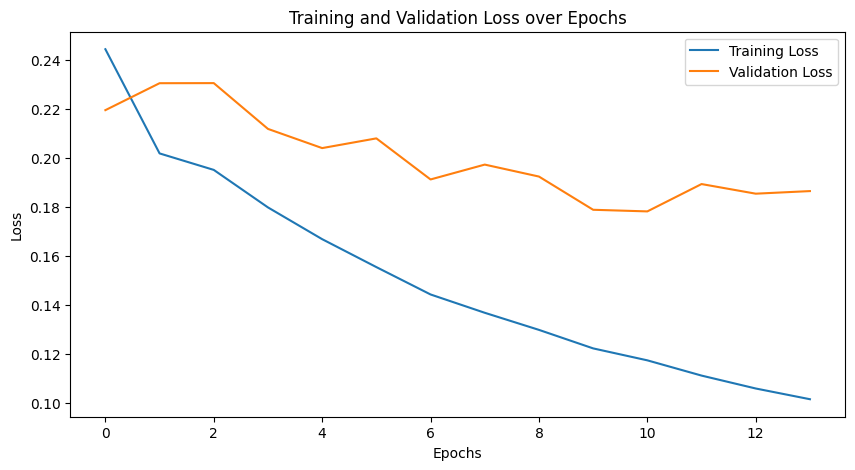

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=relu, Pool=max, Dropout=0.25, Optimizer=SGD
Epoch [1/30], Loss: 0.7007805186177268, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.699599453743468, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.6975448195099225, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6964660591267525, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [3/30], Loss: 0.6944538695255512, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6933824597521031, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [4/30], Loss: 0.6913390493937556, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.69029

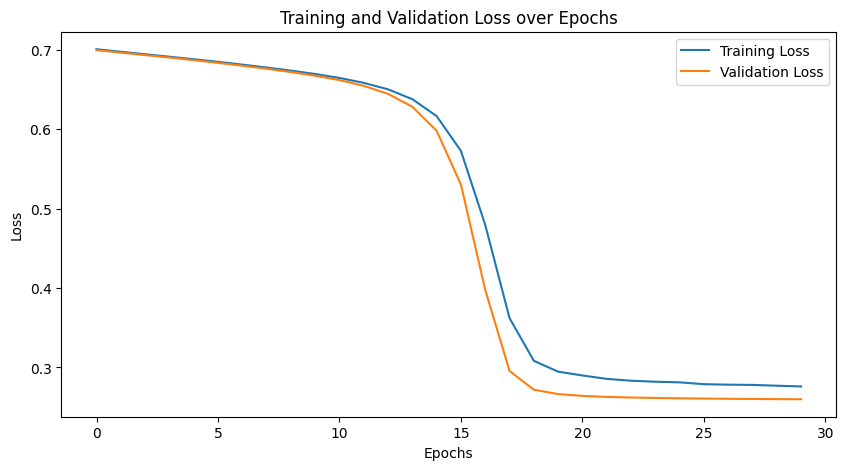

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=relu, Pool=max, Dropout=0.5, Optimizer=Adam
Epoch [1/30], Loss: 0.274351432314379, Train Exact Match Accuracy: 0.626984126984127, Train Hamming Accuracy: 87.7965367965368, Validation Loss: 0.21697595588704374, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.67070707070707
Epoch [2/30], Loss: 0.2135471096498712, Train Exact Match Accuracy: 2.071428571428571, Train Hamming Accuracy: 93.03968253968254, Validation Loss: 0.2223068113498231, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.7959595959596
Epoch [3/30], Loss: 0.2054783201913543, Train Exact Match Accuracy: 2.753968253968254, Train Hamming Accuracy: 93.58826358826359, Validation Loss: 0.22853039256594282, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.83131313131314
Epoch [4/30], Loss: 0.20140483113109764, Train Exact 

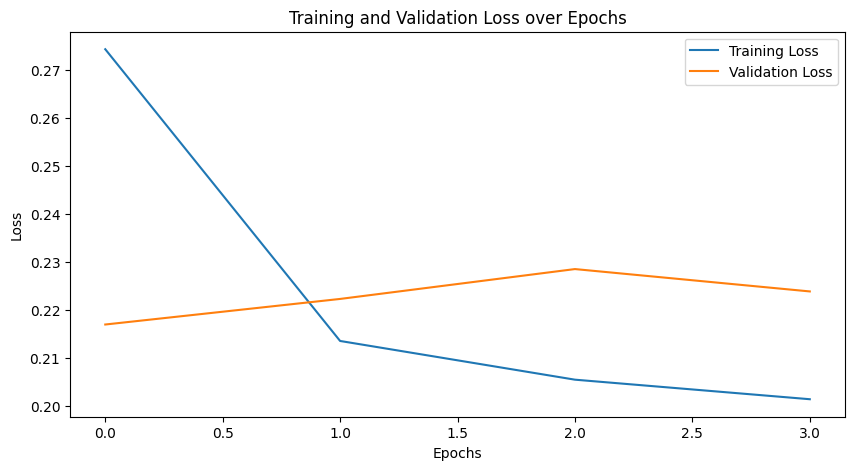

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=relu, Pool=max, Dropout=0.5, Optimizer=SGD
Epoch [1/30], Loss: 0.7013470412510906, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6992033669289123, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.6975224310068915, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6955371885857684, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [3/30], Loss: 0.6940292466412946, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6920389970566364, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [4/30], Loss: 0.6905299647507934, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.68852

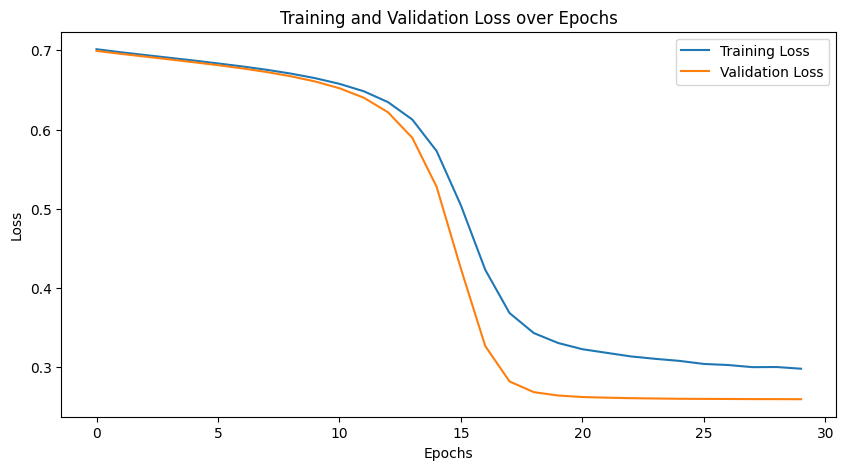

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.25, Optimizer=Adam
Epoch [1/30], Loss: 0.24150858600127514, Train Exact Match Accuracy: 1.7222222222222223, Train Hamming Accuracy: 90.96224146224147, Validation Loss: 0.22078100948574694, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.82323232323232
Epoch [2/30], Loss: 0.20017653317923473, Train Exact Match Accuracy: 3.785714285714286, Train Hamming Accuracy: 93.67027417027417, Validation Loss: 0.22797044499361135, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.83737373737374
Epoch [3/30], Loss: 0.18891490886205345, Train Exact Match Accuracy: 4.5476190476190474, Train Hamming Accuracy: 93.74699374699375, Validation Loss: 0.21818159368047688, Validation Exact Match Accuracy: 3.4333333333333336, Validation Hamming Accuracy: 93.62626262626263
Epoch [4/30], Loss: 0.171561764657194

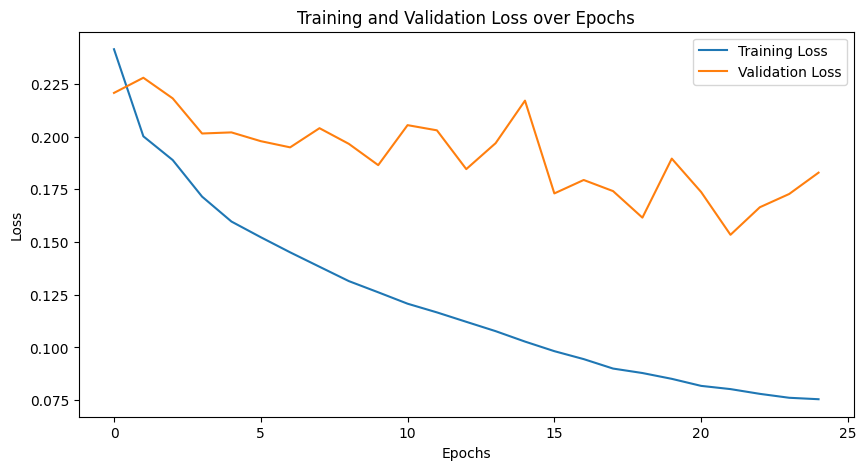

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.25, Optimizer=SGD
Epoch [1/30], Loss: 0.6893022633748611, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6864588254309715, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.6857843530662169, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6829174864799419, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [3/30], Loss: 0.6822395751318956, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6793297954062198, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [4/30], Loss: 0.6787220393945723, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 

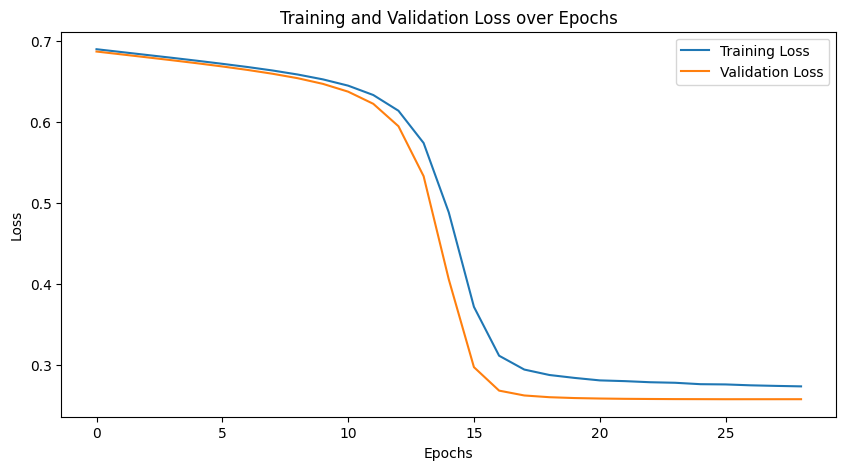

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.5, Optimizer=Adam
Epoch [1/30], Loss: 0.2728206866661909, Train Exact Match Accuracy: 0.5873015873015873, Train Hamming Accuracy: 87.88335738335739, Validation Loss: 0.21897620430335085, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.70808080808081
Epoch [2/30], Loss: 0.2140837590857811, Train Exact Match Accuracy: 2.0793650793650795, Train Hamming Accuracy: 92.9959114959115, Validation Loss: 0.22223499219151252, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.74545454545455
Epoch [3/30], Loss: 0.20532665431953323, Train Exact Match Accuracy: 2.992063492063492, Train Hamming Accuracy: 93.58032708032708, Validation Loss: 0.22996232983596782, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.82121212121211
Epoch [4/30], Loss: 0.2006658308850932, T

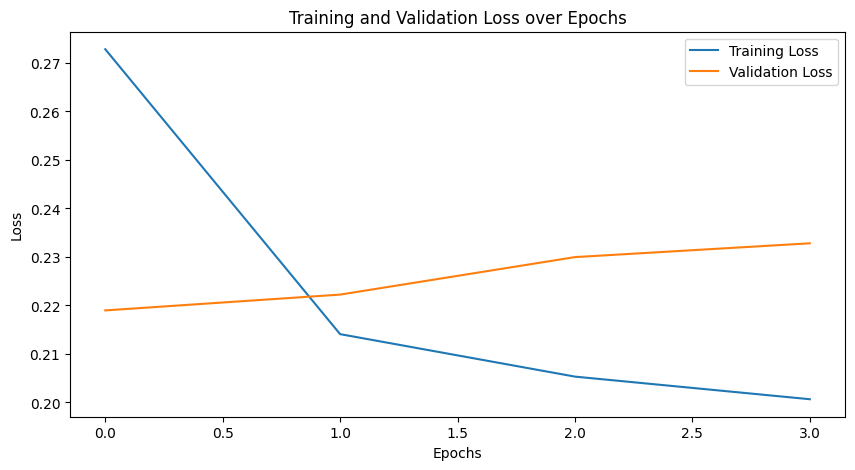

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.5, Optimizer=SGD
Epoch [1/30], Loss: 0.6905381442024018, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6889265014770183, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.6872120448175421, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6856254212399746, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [3/30], Loss: 0.6839063954232308, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6822804225252029, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [4/30], Loss: 0.6805966201469983, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0

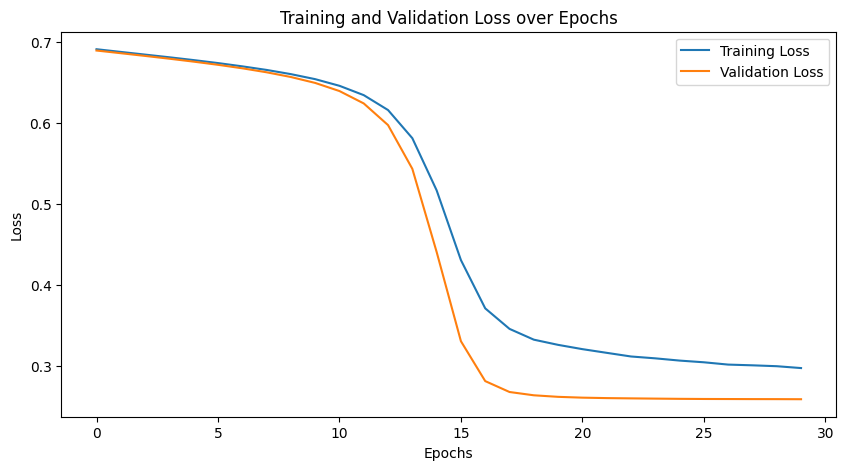

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=relu, Pool=max, Dropout=0.25, Optimizer=Adam
Epoch [1/30], Loss: 0.24381247624225422, Train Exact Match Accuracy: 1.3412698412698412, Train Hamming Accuracy: 90.42352092352093, Validation Loss: 0.21595958303263846, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.76363636363637
Epoch [2/30], Loss: 0.2008891706993132, Train Exact Match Accuracy: 3.2063492063492065, Train Hamming Accuracy: 93.52813852813853, Validation Loss: 0.23039768041765435, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.72828282828283
Epoch [3/30], Loss: 0.19390157194155727, Train Exact Match Accuracy: 4.150793650793651, Train Hamming Accuracy: 93.64165464165464, Validation Loss: 0.2423856134546247, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.88080808080808
Epoch [4/30], Loss: 0.1824531809705768, Train

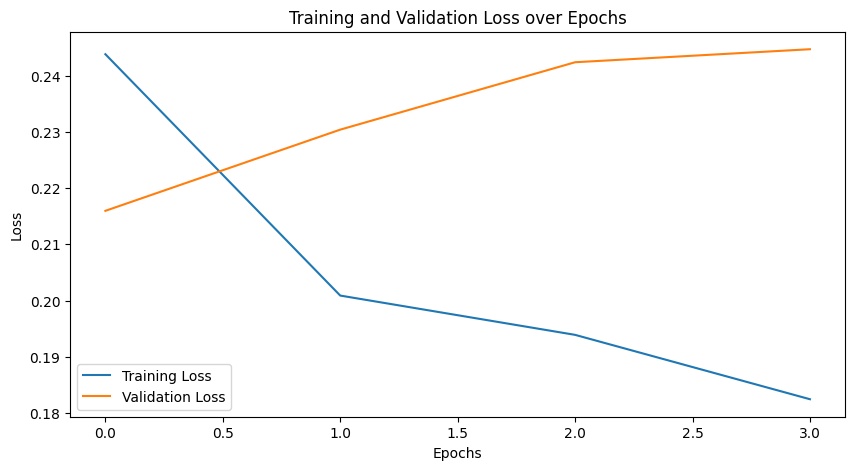

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=relu, Pool=max, Dropout=0.25, Optimizer=SGD
Epoch [1/30], Loss: 0.6796089179322199, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6766935193792303, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.6740115646480909, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.670893390127953, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [3/30], Loss: 0.6681390490931303, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6643641324753456, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [4/30], Loss: 0.6602160578149224, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.65452

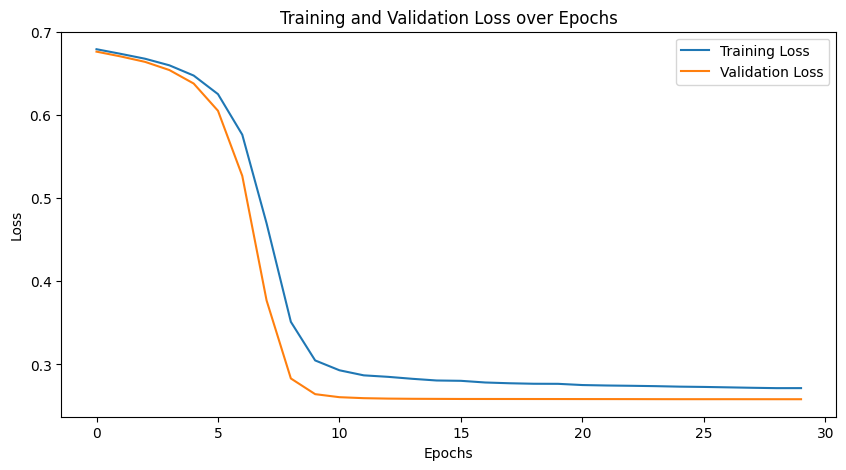

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=relu, Pool=max, Dropout=0.5, Optimizer=Adam
Epoch [1/30], Loss: 0.2686173724492794, Train Exact Match Accuracy: 0.7698412698412699, Train Hamming Accuracy: 88.38961038961038, Validation Loss: 0.21469757309619417, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.72323232323232
Epoch [2/30], Loss: 0.2140476960064796, Train Exact Match Accuracy: 1.9523809523809523, Train Hamming Accuracy: 92.98051948051949, Validation Loss: 0.21951205628190903, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.67777777777778
Epoch [3/30], Loss: 0.20530167059396123, Train Exact Match Accuracy: 2.634920634920635, Train Hamming Accuracy: 93.52308802308802, Validation Loss: 0.22637552474724484, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.54545454545455
Epoch [4/30], Loss: 0.20099307192007299, Train

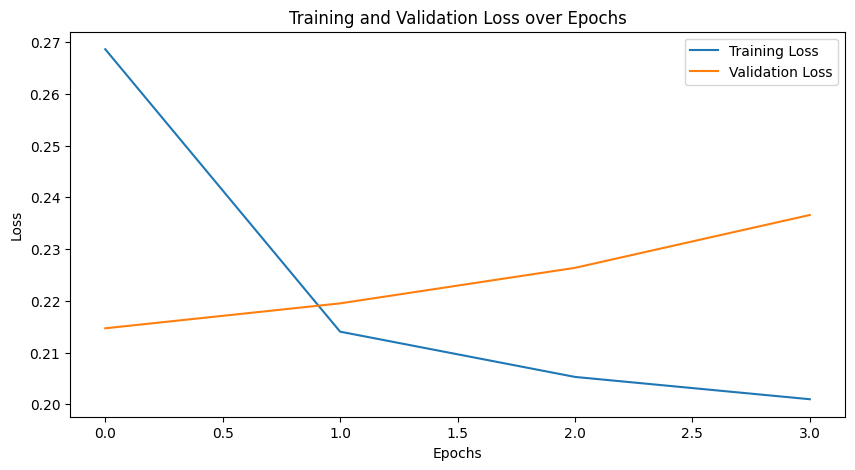

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=relu, Pool=max, Dropout=0.5, Optimizer=SGD
Epoch [1/30], Loss: 0.6886167031556821, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6854519539691032, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.6835810520927313, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6803961725945168, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [3/30], Loss: 0.6787644854656936, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6751511940296661, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [4/30], Loss: 0.6730127287697671, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.66849

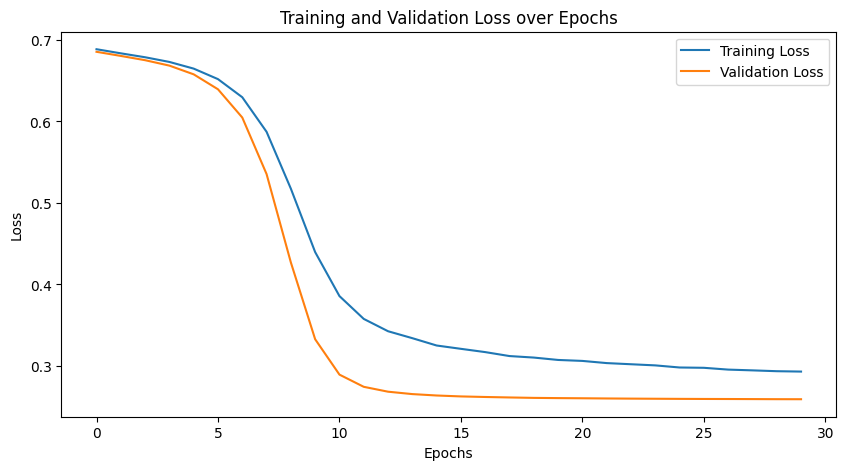

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.25, Optimizer=Adam
Epoch [1/30], Loss: 0.24448533235165068, Train Exact Match Accuracy: 1.2857142857142856, Train Hamming Accuracy: 90.27753727753728, Validation Loss: 0.216956667166124, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.51010101010101
Epoch [2/30], Loss: 0.20084225632212488, Train Exact Match Accuracy: 3.6349206349206344, Train Hamming Accuracy: 93.5913900913901, Validation Loss: 0.22425050715460104, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.78787878787878
Epoch [3/30], Loss: 0.19375842178079683, Train Exact Match Accuracy: 4.301587301587301, Train Hamming Accuracy: 93.71741221741222, Validation Loss: 0.22808829755423235, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.84747474747475
Epoch [4/30], Loss: 0.18404954494104772,

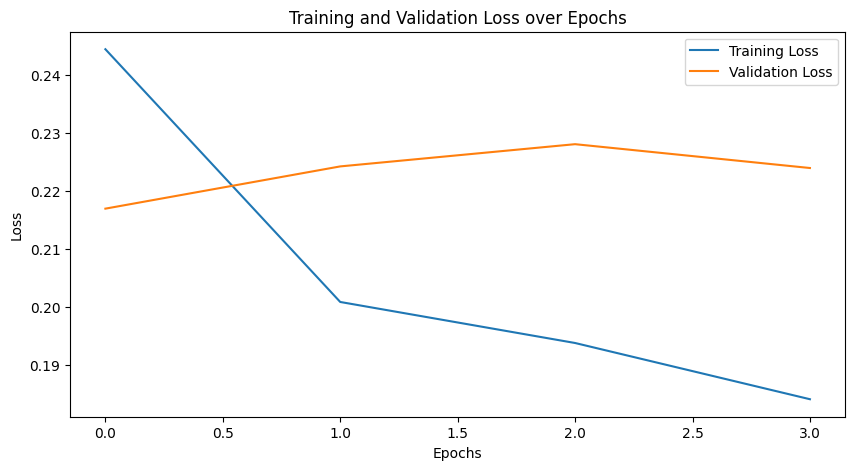

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.25, Optimizer=SGD
Epoch [1/30], Loss: 0.6974741491266918, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6936906899543519, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.6916439047622197, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6887186454965714, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [3/30], Loss: 0.6868885182184616, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6835391014180285, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [4/30], Loss: 0.681554162714082, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0

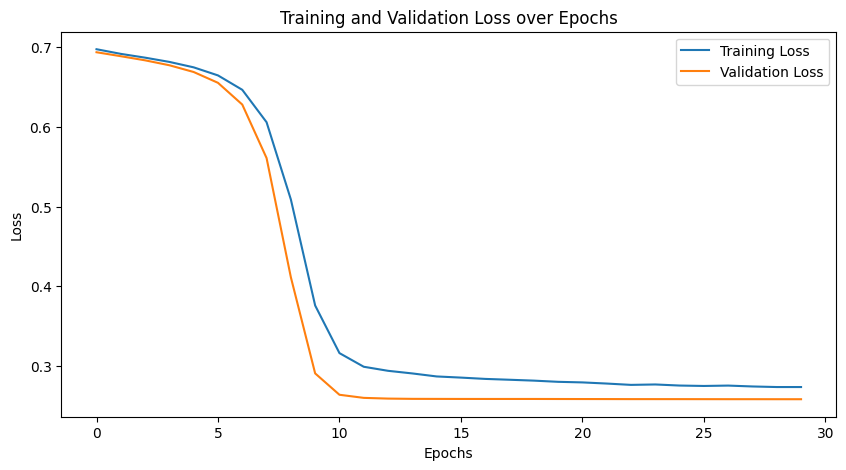

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.5, Optimizer=Adam
Epoch [1/30], Loss: 0.2753186772014889, Train Exact Match Accuracy: 0.5238095238095238, Train Hamming Accuracy: 87.38576238576239, Validation Loss: 0.2176192581178026, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.69090909090909
Epoch [2/30], Loss: 0.2138538203641848, Train Exact Match Accuracy: 2.134920634920635, Train Hamming Accuracy: 92.998075998076, Validation Loss: 0.22397540957528225, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.66969696969697
Epoch [3/30], Loss: 0.20527946491380633, Train Exact Match Accuracy: 3.015873015873016, Train Hamming Accuracy: 93.5949975949976, Validation Loss: 0.23337404917370766, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.7060606060606
Epoch [4/30], Loss: 0.20102637113653463, Train

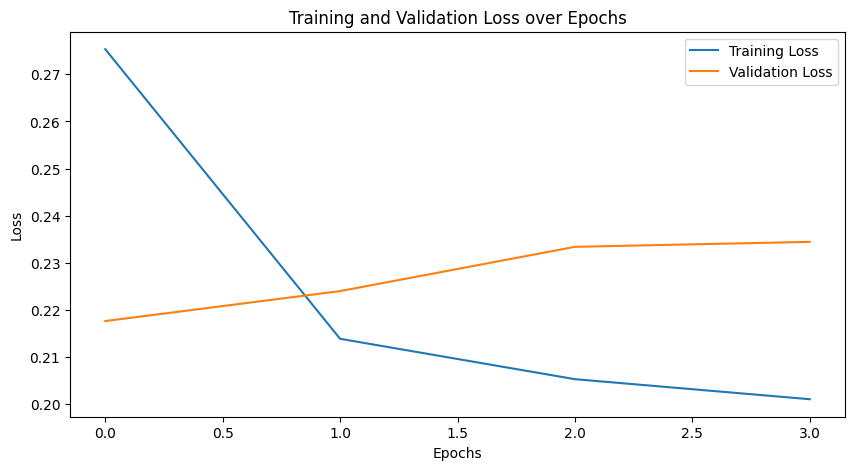

Testing Combination: Learning rate=0.001, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.5, Optimizer=SGD
Epoch [1/30], Loss: 0.6866562348331897, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6835361066016745, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.6817461146315947, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6781822271803593, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [3/30], Loss: 0.6765174582827514, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6723999774202387, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [4/30], Loss: 0.6705218052803562, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0

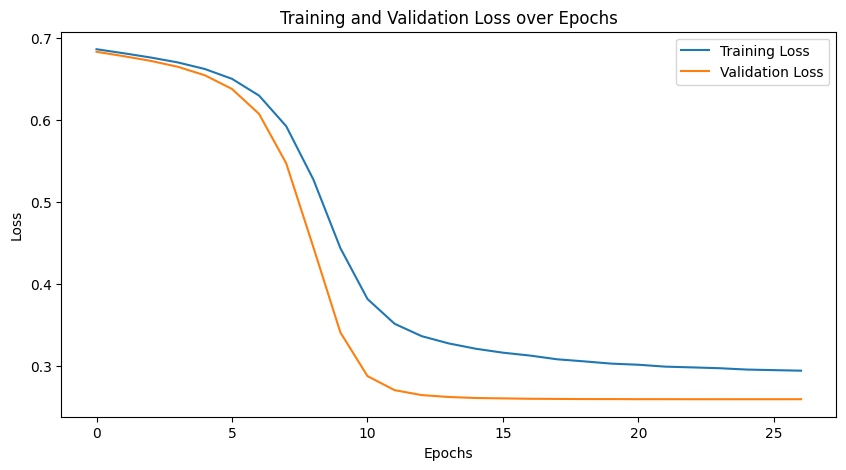

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=relu, Pool=max, Dropout=0.25, Optimizer=Adam
Epoch [1/30], Loss: 0.3228183267685363, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 91.48003848003849, Validation Loss: 0.2614841377164455, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [2/30], Loss: 0.2548604224463405, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.35930735930737, Validation Loss: 0.259458674553861, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.25378533834733336, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.36243386243386, Validation Loss: 0.2603047712052122, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.25345522127478254, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.3941798941799, Validation Loss: 0.2578

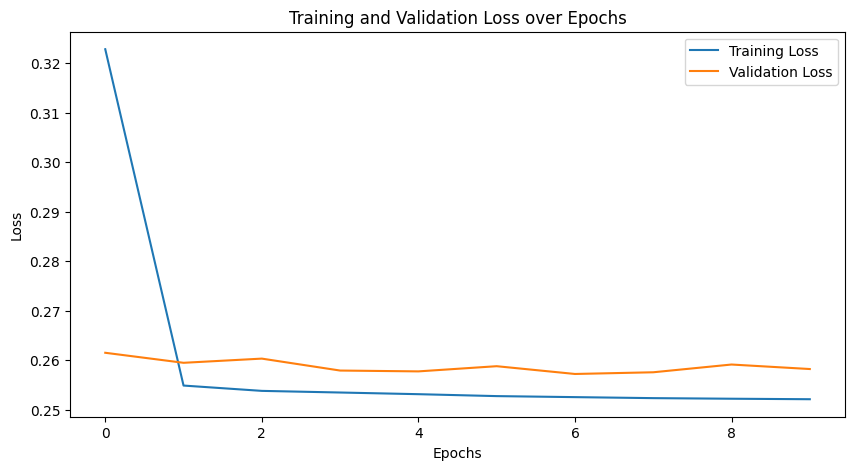

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=relu, Pool=max, Dropout=0.25, Optimizer=SGD
Epoch [1/30], Loss: 0.6816115839227201, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6619823270655693, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.5192598588575567, Train Exact Match Accuracy: 0.031746031746031744, Train Hamming Accuracy: 35.28090428090428, Validation Loss: 0.2638398838487077, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.27891738864068455, Train Exact Match Accuracy: 0.16666666666666669, Train Hamming Accuracy: 90.18037518037518, Validation Loss: 0.25889244184215016, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.27229145101181745, Train Exact Match Accuracy: 0.15873015873015872, Train Hamming A

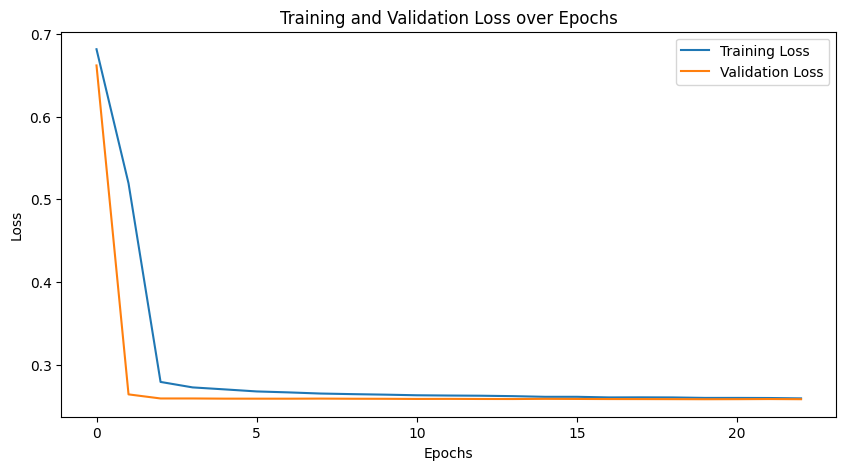

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=relu, Pool=max, Dropout=0.5, Optimizer=Adam
Epoch [1/30], Loss: 0.3220578065605333, Train Exact Match Accuracy: 0.015873015873015872, Train Hamming Accuracy: 91.41341991341992, Validation Loss: 0.25766628948931997, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [2/30], Loss: 0.2555419330669539, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.32034632034633, Validation Loss: 0.2586003101252495, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.2543630899133416, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.37734487734488, Validation Loss: 0.2584022247093789, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.2536261784773188, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.37854737854738, Valida

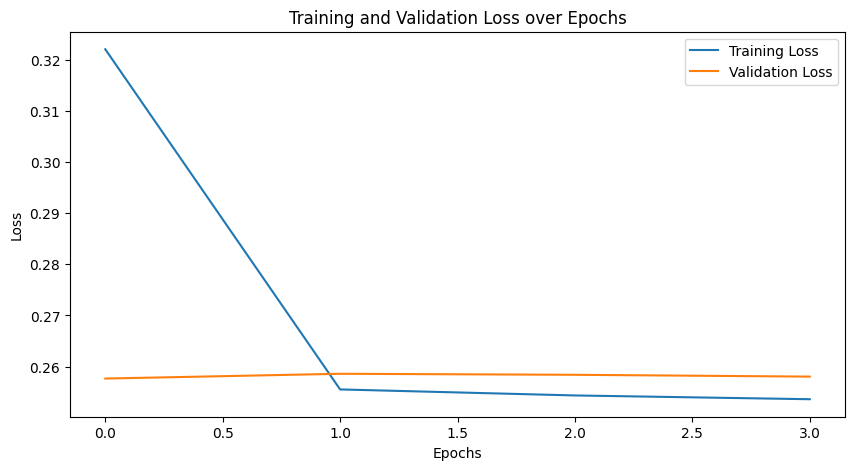

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=relu, Pool=max, Dropout=0.5, Optimizer=SGD
Epoch [1/30], Loss: 0.6692311461201779, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.113275613275613, Validation Loss: 0.6106644393281734, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.402807617550574, Train Exact Match Accuracy: 0.023809523809523808, Train Hamming Accuracy: 64.67291967291968, Validation Loss: 0.26150707409102864, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.30465432782161056, Train Exact Match Accuracy: 0.15873015873015872, Train Hamming Accuracy: 86.56589706589706, Validation Loss: 0.2596616794137245, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.2921374599038042, Train Exact Match Accuracy: 0.1507936507936508, Train Hamming Accur

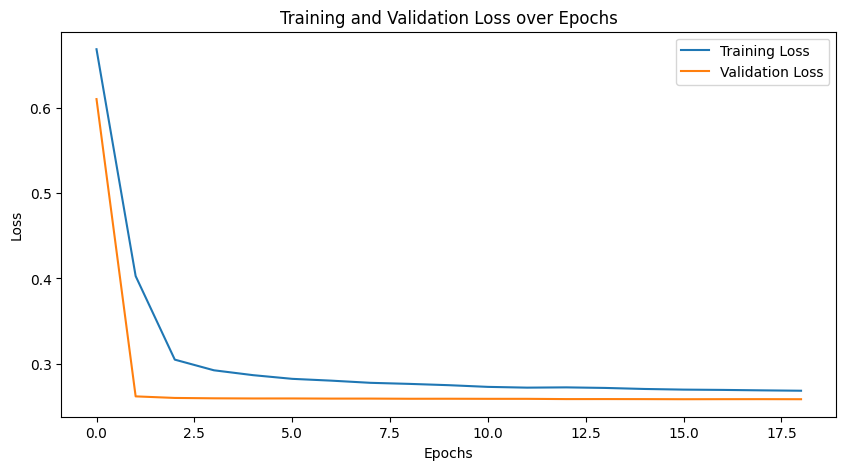

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.25, Optimizer=Adam
Epoch [1/30], Loss: 0.33415823350400486, Train Exact Match Accuracy: 0.031746031746031744, Train Hamming Accuracy: 91.44877344877345, Validation Loss: 0.25958517114532753, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [2/30], Loss: 0.2540552904687557, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.35569985569985, Validation Loss: 0.2611530280493675, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.2535291042575981, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.36748436748437, Validation Loss: 0.25794042028645253, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.25312976826568545, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.369648869648

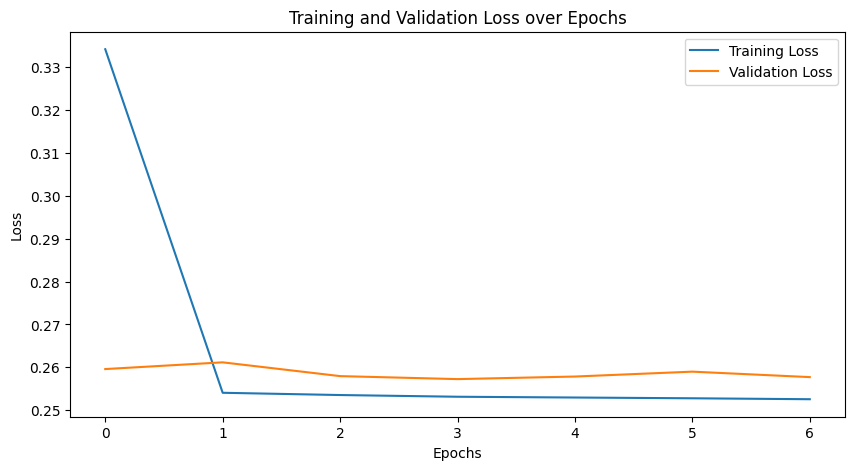

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.25, Optimizer=SGD
Epoch [1/30], Loss: 0.6831022352736613, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6634052814321315, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.5553991163745144, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 26.632034632034635, Validation Loss: 0.2704686129346807, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.28112687692424365, Train Exact Match Accuracy: 0.03968253968253968, Train Hamming Accuracy: 90.19071669071668, Validation Loss: 0.25842596844155735, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.27181203920526553, Train Exact Match Accuracy: 0.047619047619047616, Train Hamming Accuracy: 

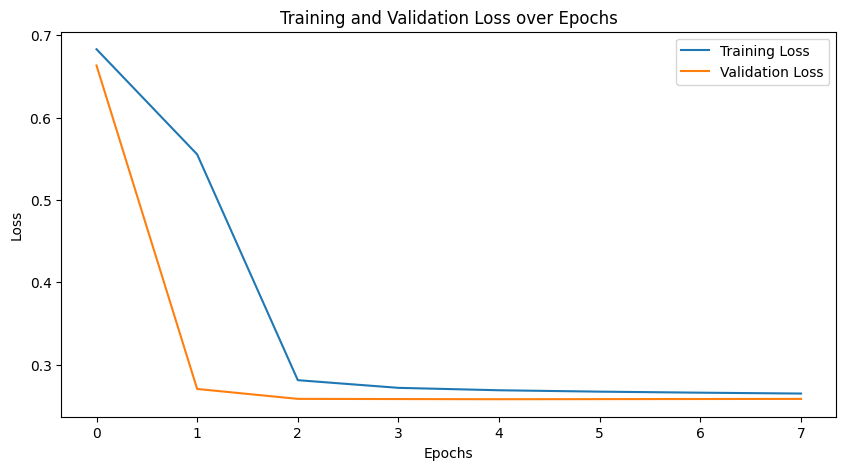

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.5, Optimizer=Adam
Epoch [1/30], Loss: 0.3040468631132605, Train Exact Match Accuracy: 0.015873015873015872, Train Hamming Accuracy: 91.38167388167389, Validation Loss: 0.2593268377983824, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [2/30], Loss: 0.25544973156476386, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.35137085137085, Validation Loss: 0.2590516726387308, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.2542969183949044, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.36604136604136, Validation Loss: 0.25716960430145264, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.2537914432849981, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.38191438191438,

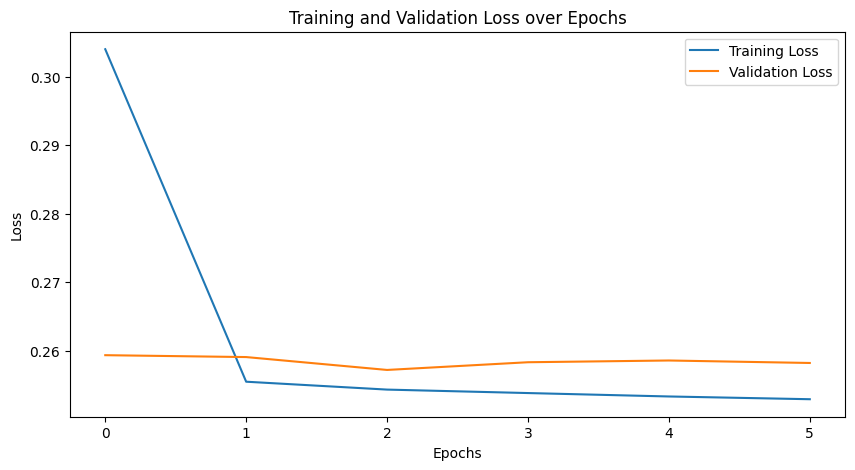

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=4, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.5, Optimizer=SGD
Epoch [1/30], Loss: 0.666494924858742, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 9.090909090909092, Validation Loss: 0.6409270275146404, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 9.090909090909092
Epoch [2/30], Loss: 0.4753586477434575, Train Exact Match Accuracy: 0.031746031746031744, Train Hamming Accuracy: 45.01875901875902, Validation Loss: 0.2612585637797701, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.30281207782362923, Train Exact Match Accuracy: 0.10317460317460318, Train Hamming Accuracy: 86.95502645502646, Validation Loss: 0.2596001957959317, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.2889203933743656, Train Exact Match Accuracy: 0.1746031746031746, Train Hamming 

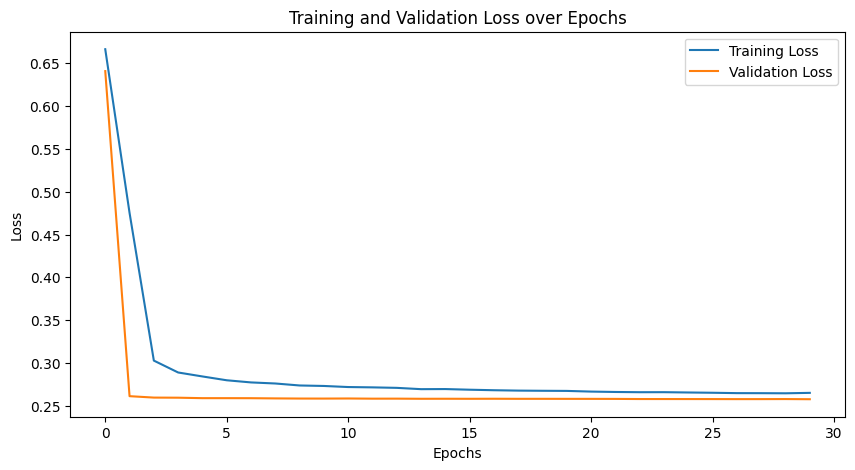

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=relu, Pool=max, Dropout=0.25, Optimizer=Adam
Epoch [1/30], Loss: 0.2935187790523931, Train Exact Match Accuracy: 0.007936507936507936, Train Hamming Accuracy: 91.61952861952862, Validation Loss: 0.25830283729319875, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [2/30], Loss: 0.2542617842933248, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.35834535834536, Validation Loss: 0.25621920300925033, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.25366240603669643, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.34559884559884, Validation Loss: 0.2587108894231472, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.25334859544855687, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.36459836459836, Va

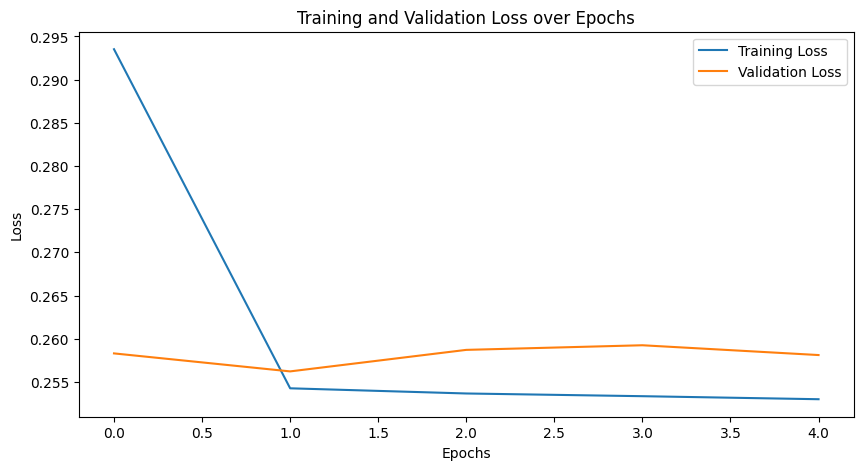

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=relu, Pool=max, Dropout=0.25, Optimizer=SGD
Epoch [1/30], Loss: 0.5761592211154511, Train Exact Match Accuracy: 0.0873015873015873, Train Hamming Accuracy: 26.535594035594034, Validation Loss: 0.2643154391900022, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [2/30], Loss: 0.28701594978722217, Train Exact Match Accuracy: 0.14285714285714285, Train Hamming Accuracy: 88.87926887926888, Validation Loss: 0.2589552491269213, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.2761979810326233, Train Exact Match Accuracy: 0.1111111111111111, Train Hamming Accuracy: 90.37061087061088, Validation Loss: 0.2584447998632776, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.27205251111899537, Train Exact Match Accuracy: 0.09523809523809523, Tr

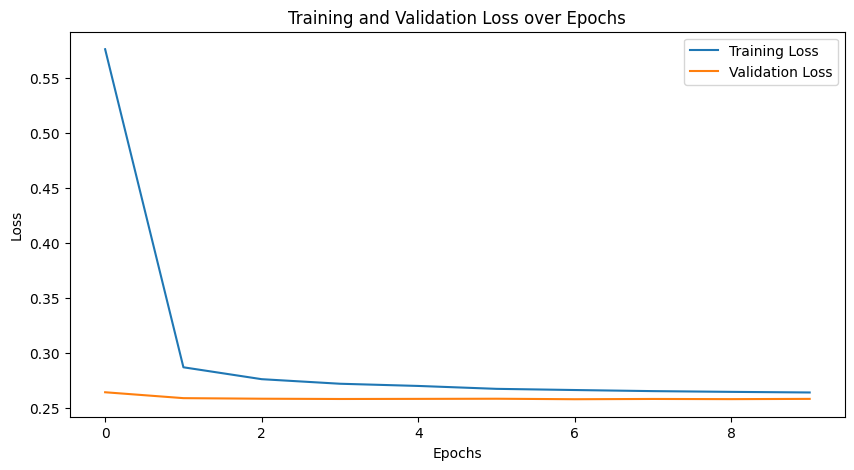

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=relu, Pool=max, Dropout=0.5, Optimizer=Adam
Epoch [1/30], Loss: 0.30913716819383164, Train Exact Match Accuracy: 0.2380952380952381, Train Hamming Accuracy: 91.26527176527176, Validation Loss: 0.23112474017320794, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.96666666666667
Epoch [2/30], Loss: 0.22317611717330624, Train Exact Match Accuracy: 2.238095238095238, Train Hamming Accuracy: 93.11135161135161, Validation Loss: 0.21679038090750258, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.5030303030303
Epoch [3/30], Loss: 0.20628793991459202, Train Exact Match Accuracy: 2.9126984126984126, Train Hamming Accuracy: 93.64478114478115, Validation Loss: 0.22486066104883842, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.76565656565657
Epoch [4/30], Loss: 0.218489890435928, Train Exact Match Accu

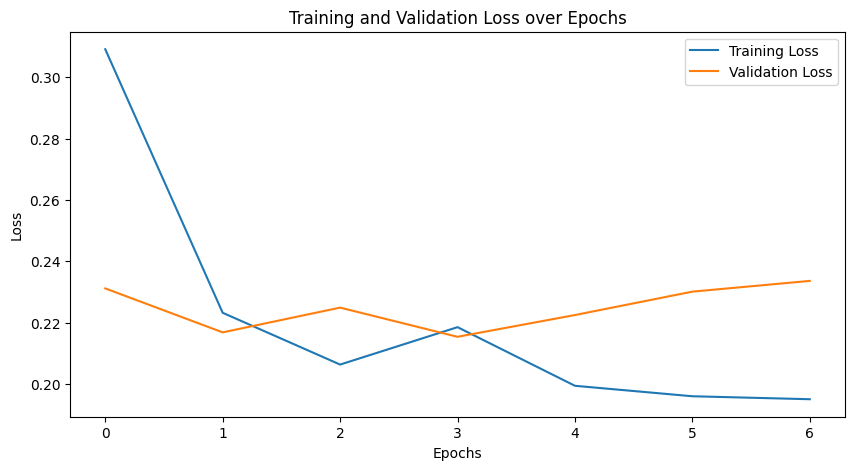

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=relu, Pool=max, Dropout=0.5, Optimizer=SGD
Epoch [1/30], Loss: 0.6155363564866448, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 20.143338143338145, Validation Loss: 0.32449942256541964, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 80.93333333333334
Epoch [2/30], Loss: 0.3231314252021954, Train Exact Match Accuracy: 0.07142857142857142, Train Hamming Accuracy: 83.23400673400674, Validation Loss: 0.26060826046035646, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.29484716367903097, Train Exact Match Accuracy: 0.1111111111111111, Train Hamming Accuracy: 88.01827801827801, Validation Loss: 0.2591816431030314, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.28632177393599817, Train Exact Match Accuracy: 0.09523809523809523, Train Hamming Ac

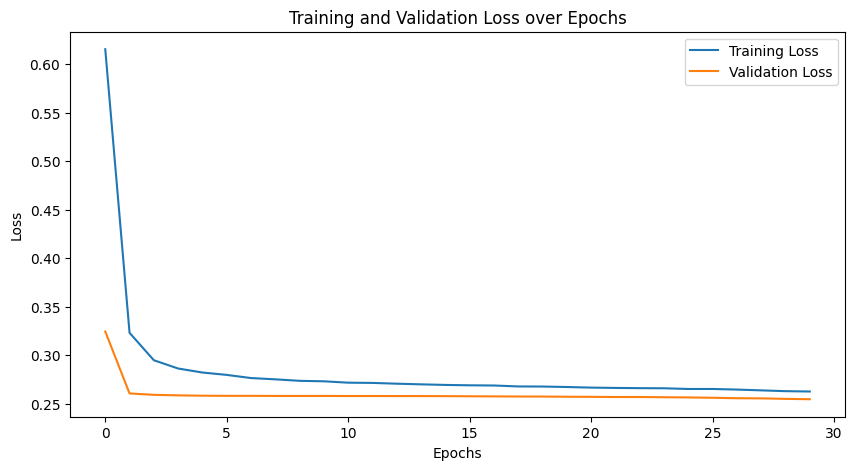

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.25, Optimizer=Adam
Epoch [1/30], Loss: 0.2596229348842263, Train Exact Match Accuracy: 1.6666666666666667, Train Hamming Accuracy: 92.29292929292929, Validation Loss: 0.22123838105100266, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.66161616161615
Epoch [2/30], Loss: 0.19796986503498204, Train Exact Match Accuracy: 3.5793650793650795, Train Hamming Accuracy: 93.81529581529581, Validation Loss: 0.22966222037026224, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.76161616161616
Epoch [3/30], Loss: 0.1917951515483372, Train Exact Match Accuracy: 4.690476190476191, Train Hamming Accuracy: 93.72005772005771, Validation Loss: 0.24631809528441506, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.96666666666667
Epoch [4/30], Loss: 0.18698326146542119,

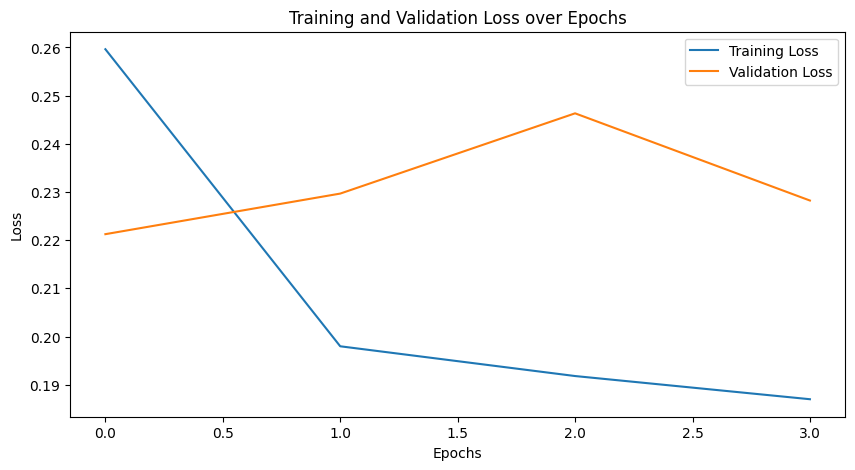

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.25, Optimizer=SGD
Epoch [1/30], Loss: 0.5460201682626898, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 33.12794612794613, Validation Loss: 0.2628527261475299, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [2/30], Loss: 0.28585952834278194, Train Exact Match Accuracy: 0.11904761904761905, Train Hamming Accuracy: 88.83501683501683, Validation Loss: 0.2583174266396685, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.2757242267506982, Train Exact Match Accuracy: 0.11904761904761905, Train Hamming Accuracy: 90.3068783068783, Validation Loss: 0.2575973478403497, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.27122389188575263, Train Exact Match Accuracy: 0.13492063492063494, Train Hammin

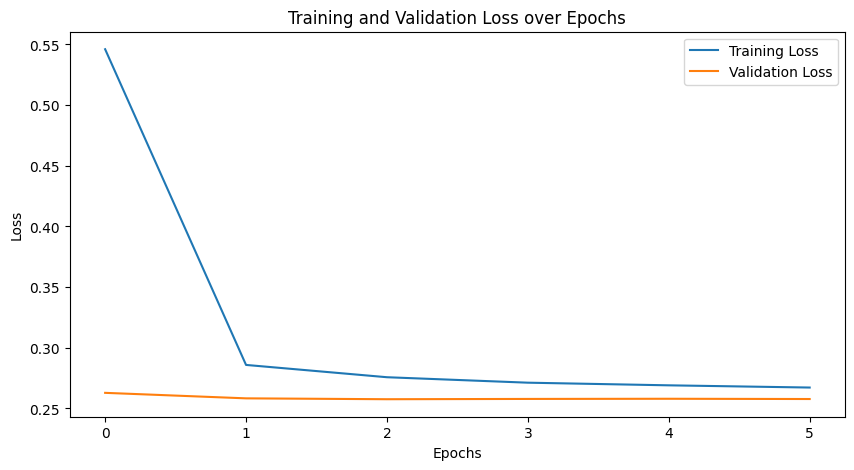

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.5, Optimizer=Adam
Epoch [1/30], Loss: 0.2950612626553792, Train Exact Match Accuracy: 0.007936507936507936, Train Hamming Accuracy: 91.30904280904281, Validation Loss: 0.25883776631127015, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [2/30], Loss: 0.2551298011377983, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.3044733044733, Validation Loss: 0.25697838340667967, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.25411914432714433, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.37830687830689, Validation Loss: 0.2583072933744877, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.25357286321935313, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 92.36676286676287

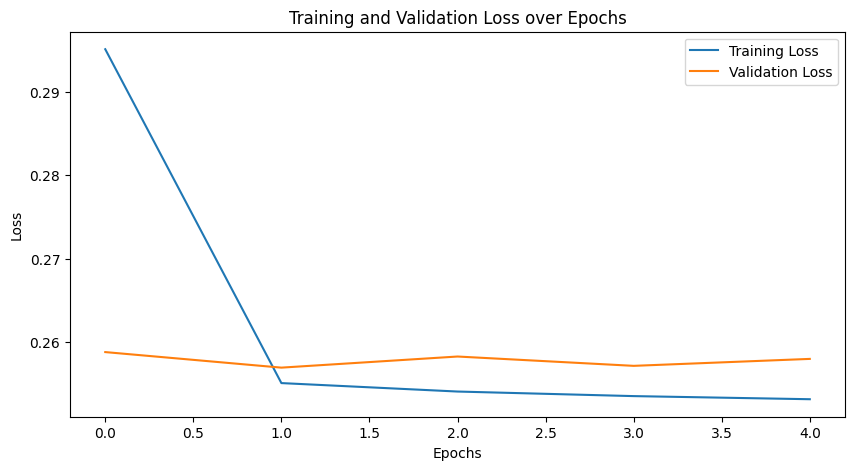

Testing Combination: Learning rate=0.01, Conv Kernel=2, Pool Kernel=2, Layers=3, Stride=2, Activation=leaky_relu, Pool=max, Dropout=0.5, Optimizer=SGD
Epoch [1/30], Loss: 0.6643334920636288, Train Exact Match Accuracy: 0.0, Train Hamming Accuracy: 10.814333814333814, Validation Loss: 0.516243207327863, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 30.147474747474746
Epoch [2/30], Loss: 0.3547283867137686, Train Exact Match Accuracy: 0.09523809523809523, Train Hamming Accuracy: 77.08225108225109, Validation Loss: 0.25997571282564325, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [3/30], Loss: 0.29887253235136796, Train Exact Match Accuracy: 0.09523809523809523, Train Hamming Accuracy: 87.34824434824435, Validation Loss: 0.2589406168207209, Validation Exact Match Accuracy: 0.0, Validation Hamming Accuracy: 92.32323232323232
Epoch [4/30], Loss: 0.2900810829425221, Train Exact Match Accuracy: 0.0873015873015873, Train Hammin

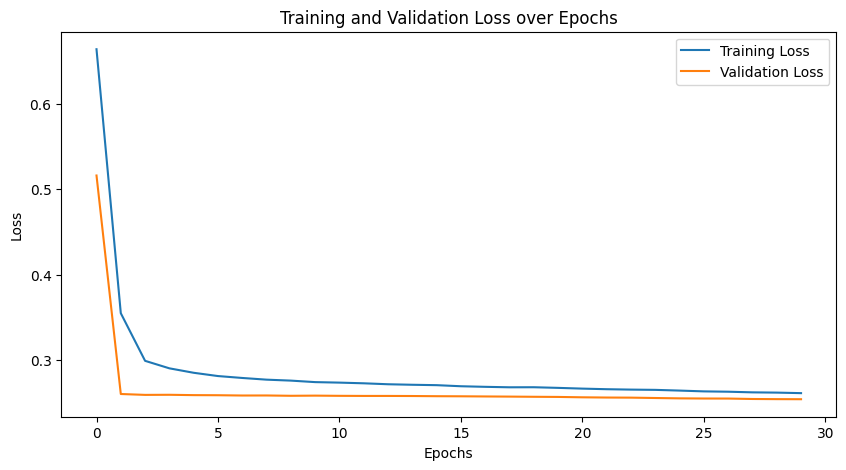


Best Validation Exact Match Accuracy: 20.033333333333335
Best Parameters: {'Learning rate': 0.001, 'Number of convolution layers': 4, 'Stride': 2, 'Activation': 'leaky_relu', 'Pooling type': 'max', 'Dropout Rate': 0.25, 'Optimizer': 'Adam'}


In [15]:
best_parameters_multi_label = {
    'Learning rate': 0.005, 
    'Number of convolution layers': 3, 
    'Stride': 2, 
    'Activation': 'relu', 
    'Pooling type': 'max', 
    'Dropout Rate': 0.25, 
    'Optimizer': 'Adam'
}
best_val_exact_match_accuracy = float(-100)
best_val_hamming_accuracy = float(-100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    for conv_k in conv_kernel_sizes:
        for pool_k in pool_kernel_sizes:
            for n_layers in num_conv_layers:
                for stride in strides:
                    for activation in activations:
                        for pool_type in pooling_types:
                            for dropout in dropout_rates:
                                for opt in optimizers:
                                    print(f"Testing Combination: Learning rate={lr}, Conv Kernel={conv_k}, Pool Kernel={pool_k}, Layers={n_layers}, Stride={stride}, Activation={activation}, Pool={pool_type}, Dropout={dropout}, Optimizer={opt}")
                                    
                                    # Initialize model with current hyperparameters
                                    model = MultiLabelCNN(
                                        optimizer=opt,
                                        activation=activation,
                                        pool_type=pool_type,
                                        stride=stride,
                                        num_conv_layers=n_layers,
                                        conv_kernel_size=conv_k,
                                        pool_kernel_size=pool_k,
                                        num_classes=33,
                                        dropout_rate=dropout
                                    ).to(device)

                                    # Train the model with current hyperparameters
                                    model.train_model(train, val,num_epochs=30, learning_rate=lr)
                                    
                                    # Evaluate model and calculate metrics
                                    mean_loss, exact_match_accuracy, hamming_accuracy = model.evaluate_model(val)
                                    
                                    # Update best parameters if current combination has a better exact match accuracy
                                    if exact_match_accuracy > best_val_exact_match_accuracy:
                                        best_parameters_multi_label = {
                                            'Learning rate': lr,
                                            'Number of convolution layers': n_layers,
                                            'Stride': stride,
                                            'Activation': activation,
                                            'Pooling type': pool_type,
                                            'Dropout Rate': dropout,
                                            'Optimizer': opt
                                        }
                                        best_val_exact_match_accuracy = exact_match_accuracy
                                        best_val_hammind_accuracy = hamming_accuracy
                                    
                                    del model
                                    gc.collect()
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                        
print("\nBest Validation Exact Match Accuracy:", best_val_exact_match_accuracy)
print("Best Parameters:", best_parameters_multi_label)

### Testing the best model on the test data

Epoch [1/30], Loss: 0.2429333555365577, Train Exact Match Accuracy: 1.5714285714285716, Train Hamming Accuracy: 90.68109668109669, Validation Loss: 0.21483709266845216, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.7979797979798
Epoch [2/30], Loss: 0.2009023180997311, Train Exact Match Accuracy: 3.619047619047619, Train Hamming Accuracy: 93.6012506012506, Validation Loss: 0.22025955860760618, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 93.81717171717172
Epoch [3/30], Loss: 0.18958214942725177, Train Exact Match Accuracy: 4.555555555555555, Train Hamming Accuracy: 93.60606060606061, Validation Loss: 0.2179473876319033, Validation Exact Match Accuracy: 3.3333333333333335, Validation Hamming Accuracy: 92.57979797979799
Epoch [4/30], Loss: 0.17152653256346126, Train Exact Match Accuracy: 6.0476190476190474, Train Hamming Accuracy: 93.09283309283309, Validation Loss: 0.19393796297632396, Validation Exact Match Accu

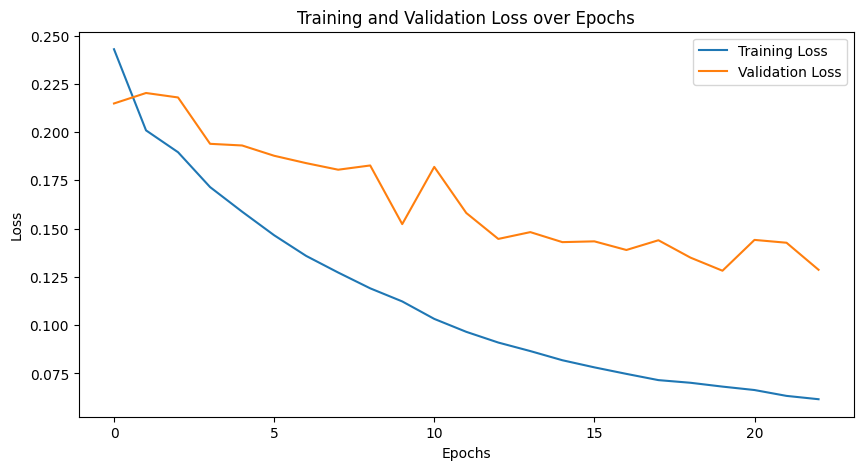

In [10]:
model = MultiLabelCNN(optimizer='Adam', activation='leaky_relu', pool_type='max', stride=2, num_conv_layers=4, conv_kernel_size=2, pool_kernel_size=2, num_classes=33, dropout_rate=0.25)
model.train_model(train, val, num_epochs = 30, learning_rate=0.001)
mean_loss, exact_match_accuracy, hamming_accuracy = model.evaluate_model(test)

In [11]:
print(f"Exact match accuracy on Test data: {exact_match_accuracy}, Hamming accuracy on test set: {hamming_accuracy}")

Exact match accuracy on Test data: 26.0, Hamming accuracy on test set: 95.79578392621872
